# XGBoost model

In [1]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [2]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [3]:
df = pd.read_csv("dataset/preprocessed_train_PCA.csv")

In [4]:
# column only for pca
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head().T

,0,1,2,3,4
StoreID,1000,1000,1000,1000,1000
Date,01/03/2016,02/03/2016,04/03/2016,05/03/2016,06/03/2016
IsHoliday,0,0,0,0,0
IsOpen,1,1,1,1,0
HasPromotions,0,0,0,0,0
StoreType,Hyper Market,Hyper Market,Hyper Market,Hyper Market,Hyper Market
AssortmentType,General,General,General,General,General
NearestCompetitor,326,326,326,326,326
Region,7,7,7,7,7
NumberOfCustomers,495,608,665,630,0


In [5]:
# removing all rows for which store is closed
df = df[df.IsOpen == 1]

df.drop(['NumberOfCustomers','Date'], axis=1, inplace=True)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [6]:
#for now let's drop unusable categorical vars
df.drop(['StoreType','AssortmentType','Events'], axis=1, inplace=True)
df.head().T

,0,1,2,3,5
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
IsOpen,1.000000,1.000000,1.000000,1.000000,1.000000
HasPromotions,0.000000,0.000000,0.000000,0.000000,1.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,5676.000000,8111.000000,8300.000000,7154.000000,10110.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000


In [7]:
df.head(20).T

,0,1,2,3,5,6,7,8,9,10,12,13,14,15,16,17,19,20,21,22
StoreID,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IsOpen,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
HasPromotions,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,5676.000000,8111.000000,8300.000000,7154.000000,10110.000000,9019.000000,8804.000000,7823.000000,7989.000000,5895.000000,6348.000000,4738.000000,6014.000000,6087.000000,6962.000000,6618.000000,9183.000000,8155.000000,7109.000000,8041.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000


In [8]:
df.shape

(433958, 42)

In [9]:
train = md.get_fake_train(df)

In [10]:
train.shape

(397047, 42)

In [11]:
test = md.get_fake_test(df)
test.shape

(36911, 42)

In [12]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [13]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('IsOpen')
features.remove('D_DayOfweek')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
#features.remove('Min_Dew_PointC')
#features.remove('Max_Wind_SpeedKm_h')
#features.remove('Max_VisibilityKm')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
#features.remove('Events_Thunderstorm')
#features.remove('Events_Fog')

print("features")

pprint(features)

features
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12']


In [14]:
# remove less relevant components
#features.remove('p6')
features.remove('p8')
features.remove('p4')
features.remove('p3')
features.remove('p9')

In [15]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          #"gamma": 2  #added as a test
          }

#reg_alpha 
#reg_lambda
num_trees = 200 #400

In [16]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [17]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [18]:
X_train.shape

(377194, 42)

In [19]:
X_test.shape

(19853, 42)

In [20]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [21]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.33776	train-rmse:6.33633
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.07286	train-rmse:5.0715
[2]	test-rmse:4.06356	train-rmse:4.06226
[3]	test-rmse:3.25773	train-rmse:3.25604
[4]	test-rmse:2.61432	train-rmse:2.61205
[5]	test-rmse:2.09644	train-rmse:2.09414
[6]	test-rmse:1.68674	train-rmse:1.68398
[7]	test-rmse:1.35773	train-rmse:1.35463
[8]	test-rmse:1.09827	train-rmse:1.09451
[9]	test-rmse:0.887258	train-rmse:0.882871
[10]	test-rmse:0.720515	train-rmse:0.715154
[11]	test-rmse:0.59076	train-rmse:0.584474
[12]	test-rmse:0.490473	train-rmse:0.482753
[13]	test-rmse:0.412099	train-rmse:0.402655
[14]	test-rmse:0.351503	train-rmse:0.340217
[15]	test-rmse:0.303837	train-rmse:0.290752
[16]	test-rmse:0.270407	train-rmse:0.255571
[17]	test-rmse:0.245394	train-rmse:0.228922
[18]	test-rmse:0.227257	train-rmse:0.209284
[19]	test-rmse:0.214905	train-rmse:0.195542
[20]	

### Validating

In [22]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.1089256791956602


RMSE

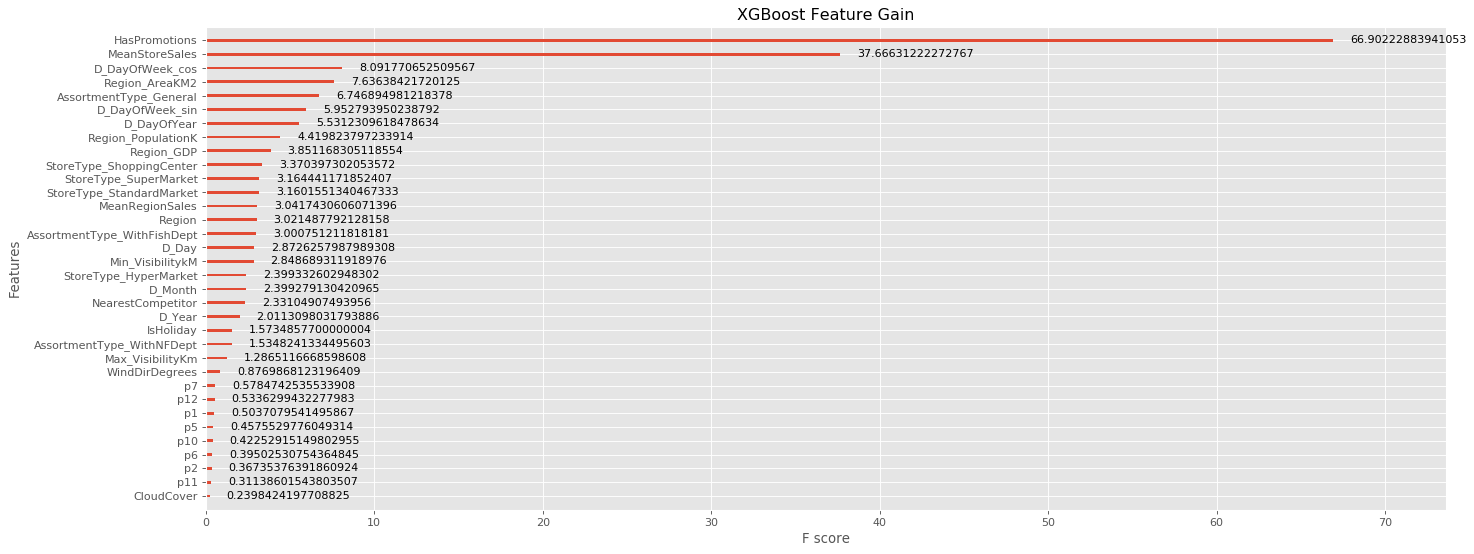

In [23]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

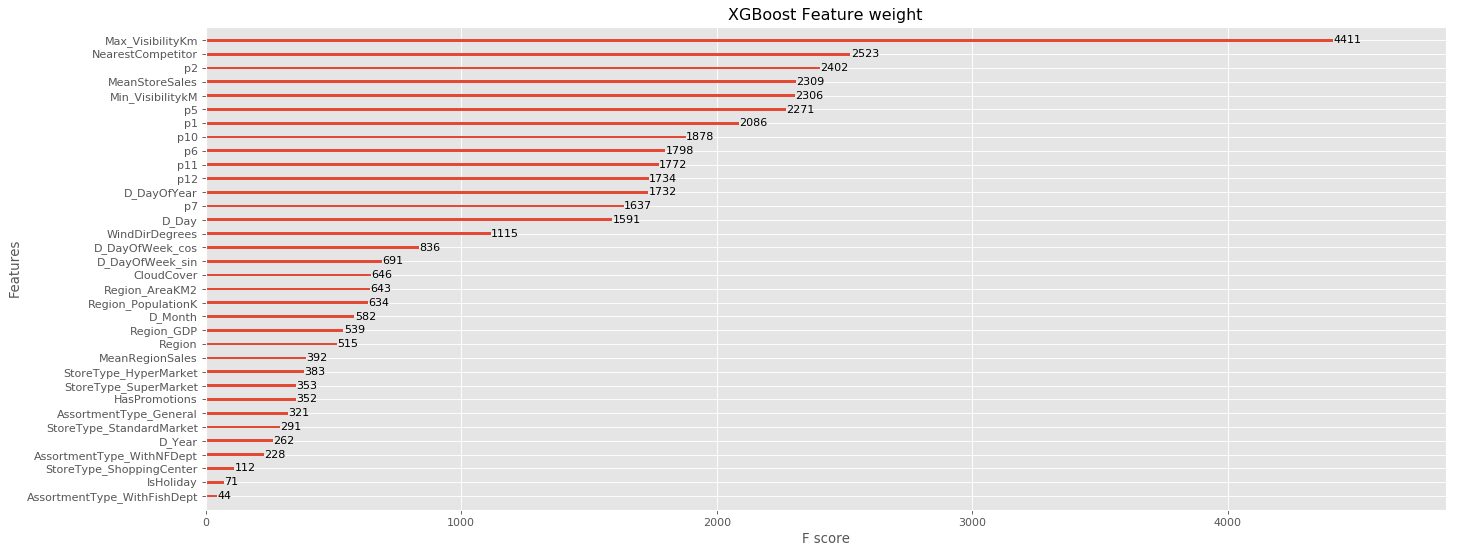

In [24]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

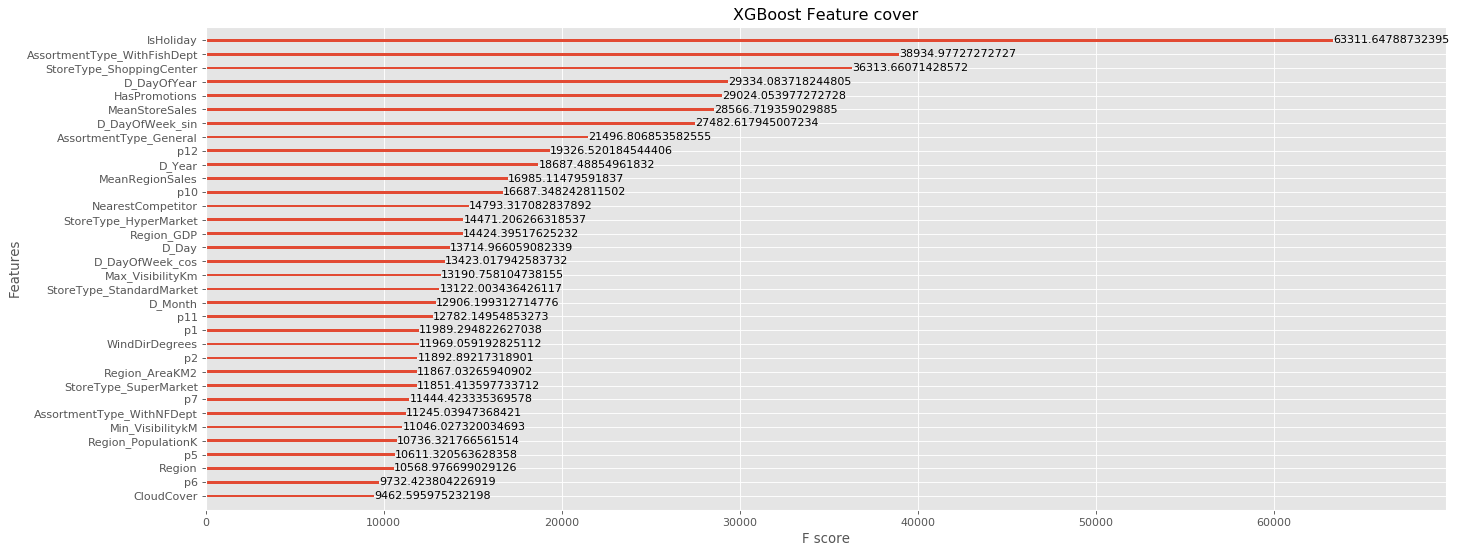

In [25]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [26]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [27]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [28]:
from BIP_error import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.04516873024811466


In [29]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [30]:
diff.head(15).T

670    -151.287109
671    1794.520508
672    -362.232910
674    -649.259277
675    -417.408691
677   -2213.343750
678   -1454.741211
679   -1185.349609
680   -1220.404785
681    -664.436523
682    -221.133789
684     121.257812
685     489.625000
686    -657.870117
687    -876.978516
dtype: float32

In [31]:
diff.mean()

-51.711788177490234

In [32]:
train_probs.shape

(36911,)

In [33]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [34]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [35]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [36]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.19920641329950234


In [37]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,6616.973633
14894,6795,7126.545410
14896,7035,6819.748047
14897,5437,5678.183105
14898,5725,6191.070312
14899,5143,6215.150879
14900,5589,6539.547363
14901,7520,5904.708984
14903,3927,4869.154785
14904,3682,4176.571289


In [38]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
14893,5468,6616.973633
14894,6795,7126.545410
14896,7035,6819.748047
14897,5437,5678.183105
14898,5725,6191.070312
14899,5143,6215.150879
14900,5589,6539.547363
14901,7520,5904.708984
14903,3927,4869.154785
14904,3682,4176.571289


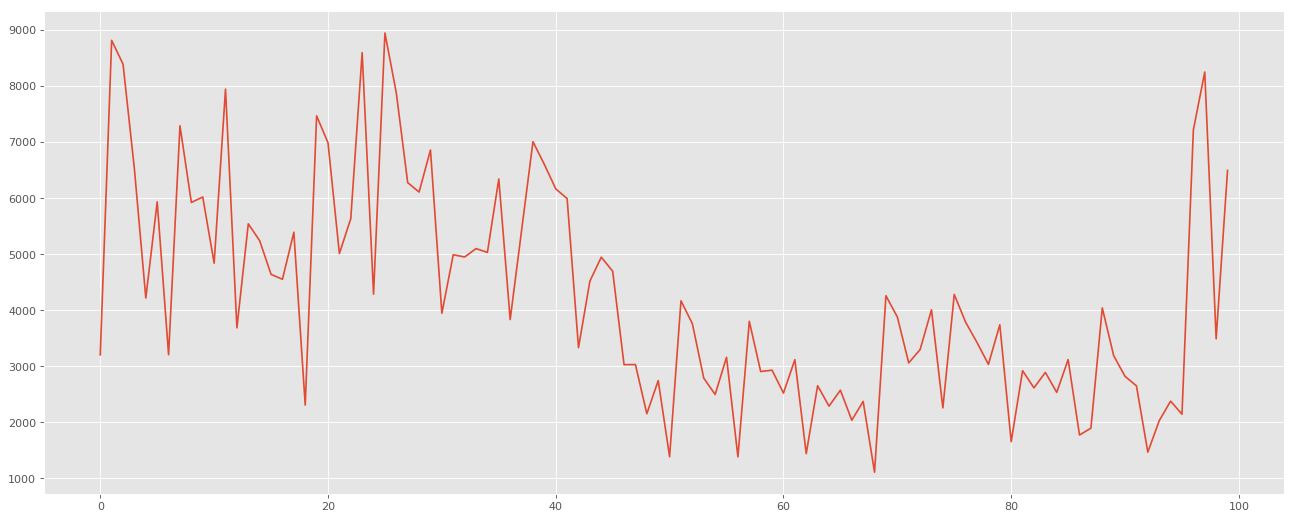

In [39]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

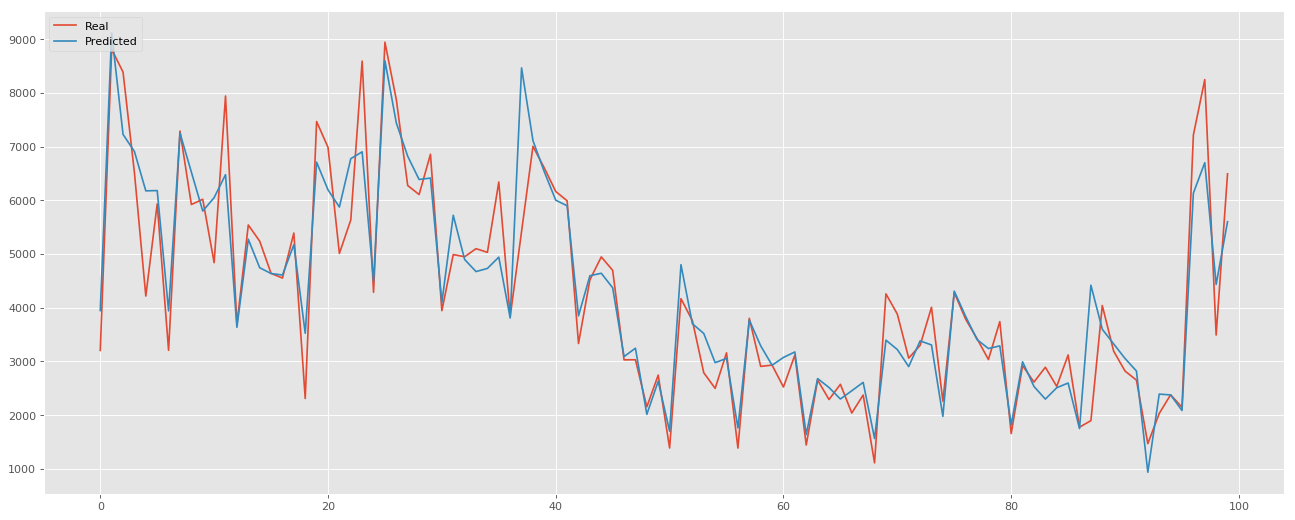

In [40]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

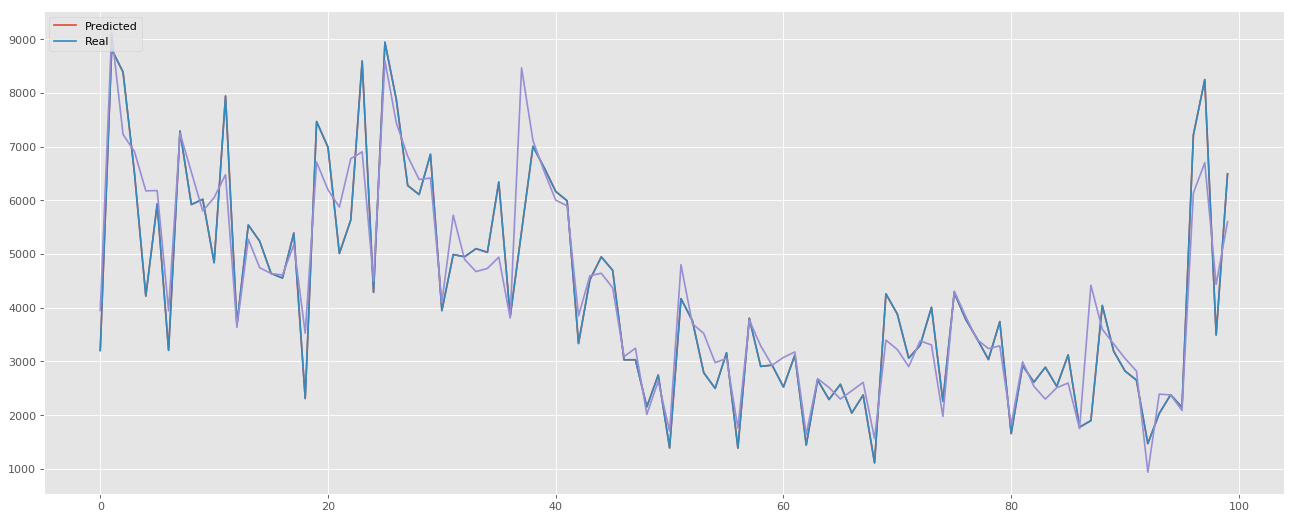

In [41]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [42]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

ValueError: operands could not be broadcast together with shapes (19853,) (36911,) 

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y